In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip 'drive/MyDrive/eye_gender_data.zip'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold

In [3]:
from google.colab import files

Get distribution of pixel values in the train and test datasets.

In [4]:
train_dir = 'eye_gender_data/train/'
test_dir = 'eye_gender_data/test/'

train_pixel_values = [cv2.imread(train_dir + f'Image_{i}.jpg').shape[0] for i in range(1, 9221)]
test_pixel_values = [cv2.imread(test_dir + f'Image_{i}.jpg').shape[0] for i in range(1, 2306)]

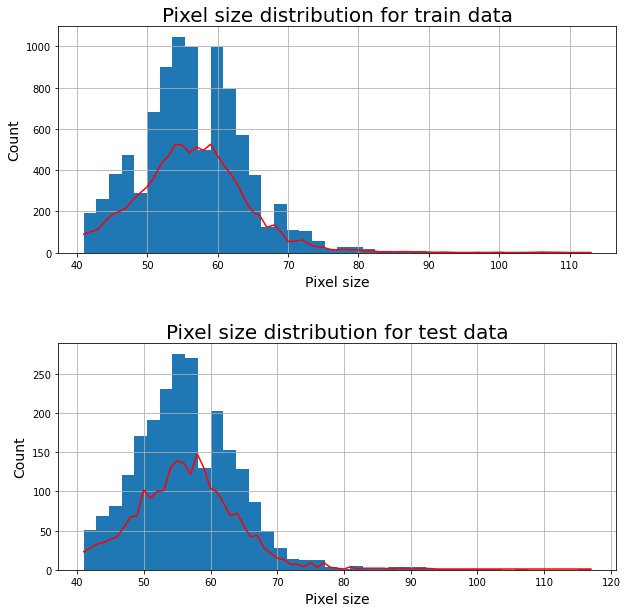

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=1)

plt.subplots_adjust(hspace=0.4)

train_unique, train_counts = np.unique(train_pixel_values, return_counts=True)
test_unique, test_counts = np.unique(test_pixel_values, return_counts=True)

ax[0].hist(train_pixel_values, bins=40)
ax[0].plot(train_unique, train_counts, color='red')
ax[0].set_title('Pixel size distribution for train data', pad=5, fontsize=20)
ax[0].set_xlabel('Pixel size', labelpad=5, fontsize=14)
ax[0].set_ylabel('Count', labelpad=5, fontsize=14)
ax[0].grid(axis='both')

ax[1].hist(test_pixel_values, bins=40)
ax[1].plot(test_unique, test_counts, color='red')
ax[1].set_title('Pixel size distribution for test data', pad=5, fontsize=20)
ax[1].set_xlabel('Pixel size', labelpad=5, fontsize=14)
ax[1].set_ylabel('Count', labelpad=5, fontsize=14)
ax[1].grid(axis='both')

plt.show()

In [ ]:
# Mean of pixel values
print('Train pixel values mean: ', round(np.mean(np.array(train_pixel_values))))
print('Test pixel values mean: ', round(np.mean(np.array(test_pixel_values))))

Train pixel values mean:  57
Test pixel values mean:  57


Get data

In [5]:
height = 57
width = 57

train_dataset = np.asarray(Image.open(train_dir + 'Image_1.jpg').resize((height, width)))
train_dataset = train_dataset.reshape((1, height, width, 3))

test_dataset = np.asarray(Image.open(test_dir + 'Image_1.jpg').resize((height, width)))
test_dataset = test_dataset.reshape((1, height, width, 3))

for i in range(2, 9221):
    img = np.asarray(Image.open(train_dir + f'Image_{i}.jpg').resize((height, width)))
    train_dataset = np.append(train_dataset, img.reshape((1, height, width, 3)), axis=0)

In [6]:
for i in range(2, 2306):
    img = np.asarray(Image.open(test_dir + f'Image_{i}.jpg').resize((height, width)))
    test_dataset = np.append(test_dataset, img.reshape((1, height, width, 3)), axis=0)

In [7]:
# 'image_dataset_from_directory' uses alphanumeric sorting, so we have to sort our labels too
train_dataset_labels = pd.read_csv('eye_gender_data/Training_set.csv')['label']

# 'male' = 0, 'female' = 1
train_label = train_dataset_labels.apply(lambda x: 0 if x=='male' else 1).values

Check the number of 'male' and 'female' samples in the train dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


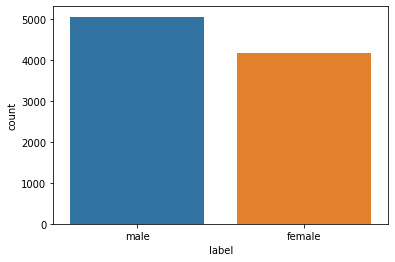

In [ ]:
sns.countplot(train_dataset_labels)

See a few of the images

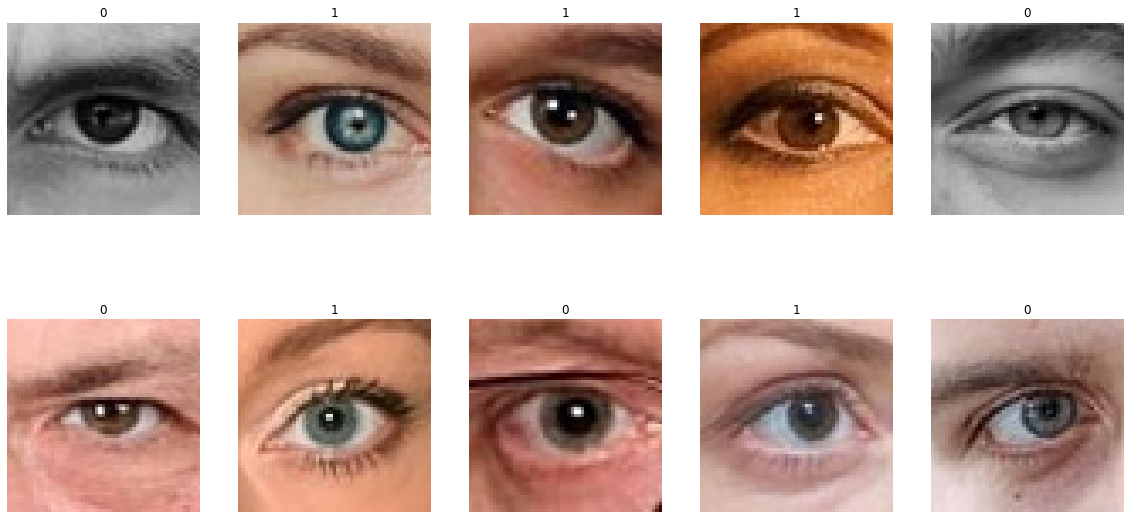

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(train_dataset[i].astype('uint8'))
    plt.title(train_label[i])
    plt.axis('off')

Applying data augmentation and seeing how it really affects an image.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

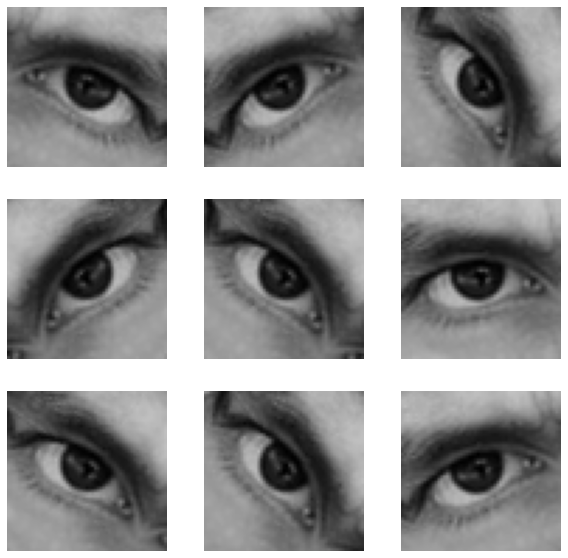

In [ ]:
plt.figure(figsize=(10, 10))
first_image = train_dataset[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Data augmentation for the dataset with training

In [8]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=60,
                                                                 horizontal_flip=True,
                                                                 rescale=1./255,
                                                                 validation_split=0.2)

data_generator.fit(train_dataset)

Using KFold cross validation to split the dataset in five

In [9]:
kfold = KFold(n_splits=5, shuffle=False)

kfold_train = []
kfold_validation = []

for train, validation in kfold.split(train_dataset, train_label):
    kfold_train.append(train)
    kfold_validation.append(validation)

Function to predict and download the test dataset for the Challenge, after the model has been trained.

In [10]:
def predict(test_dataset, filename):

    test_predict = model.predict(test_dataset / 255)

    test_predict_reshape = test_predict.reshape((2305))

    test_predict_where = np.where(test_predict_reshape < 0.5, 0, 1)

    test_predict_df = pd.DataFrame({'label': test_predict_where}, index=list(range(len(test_predict_reshape))))

    test_predict_df['label'] = test_predict_df['label'].apply(lambda x: 'male' if x==0 else 'female')

    test_predict_df.to_csv(filename, index=False)

Function to plot the training history.

In [16]:
def plot(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

<!-- model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(57, 57, 3)),

    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) -->

<!-- Try 1

Epoch 8/20
185/185 [==============================] - 173s 937ms/step - loss: 0.4131 - accuracy: 0.8118 - val_loss: 0.4150 - val_accuracy: 0.7989
Epoch 9/20
185/185 [==============================] - 159s 859ms/step - loss: 0.3905 - accuracy: 0.8304 - val_loss: 0.4208 - val_accuracy: 0.8179
Epoch 10/20
185/185 [==============================] - 75319s 409s/step - loss: 0.3681 - accuracy: 0.8377 - val_loss: 0.4339 - val_accuracy: 0.7962 -->

Creating the model and training.

Here, since there are five folds, the model will be trained five times using each of the 5 folds of the split dataset.

Due to RAM constraints, after the model is trained on each fold of the dataset, the model is saved, the runtime is restarted, then the saved model is brought back so that training can be continued on the next data fold.

After each fold though, the model is tested on the test dataset for the Challenge and submitted.

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(57, 57, 3)),

    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 128)       1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 128)       65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        2

In [16]:
# Fold 1
fold = 0

history = model.fit(data_generator.flow(train_dataset[kfold_train[fold]],
                                        train_label[kfold_train[fold]],
                                        batch_size=32, shuffle=True,
                                        subset='training'),
                    initial_epoch=0,
                    epochs=150,
                    batch_size=32,
                    validation_data = data_generator.flow(train_dataset[kfold_validation[fold]],
                                                          train_label[kfold_validation[fold]],
                                                          batch_size=32, shuffle=True, 
                                                          subset='validation')
                    )
                    #callbacks=[early_stopping])

Epoch 1/150
185/185 [==============================] - 41s 47ms/step - loss: 0.6526 - accuracy: 0.6179 - val_loss: 0.7088 - val_accuracy: 0.5815
Epoch 2/150
185/185 [==============================] - 8s 43ms/step - loss: 0.5654 - accuracy: 0.7075 - val_loss: 0.5415 - val_accuracy: 0.7391
Epoch 3/150
185/185 [==============================] - 8s 43ms/step - loss: 0.5049 - accuracy: 0.7533 - val_loss: 0.7172 - val_accuracy: 0.6929
Epoch 4/150
185/185 [==============================] - 8s 41ms/step - loss: 0.4448 - accuracy: 0.7977 - val_loss: 0.4930 - val_accuracy: 0.7582
Epoch 5/150
185/185 [==============================] - 8s 43ms/step - loss: 0.4223 - accuracy: 0.8049 - val_loss: 0.4420 - val_accuracy: 0.7989
Epoch 6/150
185/185 [==============================] - 8s 43ms/step - loss: 0.3864 - accuracy: 0.8275 - val_loss: 0.3427 - val_accuracy: 0.8505
Epoch 7/150
185/185 [==============================] - 8s 43ms/step - loss: 0.3642 - accuracy: 0.8424 - val_loss: 0.4948 - val_accuracy

In [19]:
model.save('model_kfold_fold1.h5')
files.download('model_kfold_fold1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
filename = 'submission_fold1.csv'
predict(test_dataset, filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
model = tf.keras.models.load_model('model_kfold_fold1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 128)       1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 128)       65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        2

In [13]:
# Fold 2
fold = 1

history = model.fit(data_generator.flow(train_dataset[kfold_train[fold]],
                                        train_label[kfold_train[fold]],
                                        batch_size=32, shuffle=True,
                                        subset='training'),
                    initial_epoch=150,
                    epochs=300,
                    batch_size=32,
                    validation_data = data_generator.flow(train_dataset[kfold_validation[fold]],
                                                          train_label[kfold_validation[fold]],
                                                          batch_size=32, shuffle=True, 
                                                          subset='validation')
                    )
                    #callbacks=[early_stopping])

Epoch 151/300
185/185 [==============================] - 16s 44ms/step - loss: 0.0827 - accuracy: 0.9681 - val_loss: 0.2435 - val_accuracy: 0.9348
Epoch 152/300
185/185 [==============================] - 8s 41ms/step - loss: 0.0918 - accuracy: 0.9659 - val_loss: 0.2172 - val_accuracy: 0.9321
Epoch 153/300
185/185 [==============================] - 8s 41ms/step - loss: 0.0879 - accuracy: 0.9636 - val_loss: 0.1859 - val_accuracy: 0.9375
Epoch 154/300
185/185 [==============================] - 8s 43ms/step - loss: 0.0926 - accuracy: 0.9651 - val_loss: 0.2169 - val_accuracy: 0.9239
Epoch 155/300
185/185 [==============================] - 8s 43ms/step - loss: 0.0869 - accuracy: 0.9653 - val_loss: 0.1847 - val_accuracy: 0.9348
Epoch 156/300
185/185 [==============================] - 8s 44ms/step - loss: 0.0861 - accuracy: 0.9697 - val_loss: 0.2050 - val_accuracy: 0.9375
Epoch 157/300
185/185 [==============================] - 8s 41ms/step - loss: 0.0912 - accuracy: 0.9644 - val_loss: 0.2097 

In [14]:
model.save('model_kfold_fold2.h5')
files.download('model_kfold_fold2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
filename = 'submission_fold2.csv'
predict(test_dataset, filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
model = tf.keras.models.load_model('model_kfold_fold2.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 128)       1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 128)       65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        2

In [12]:
# Fold 3
fold = 2

history = model.fit(data_generator.flow(train_dataset[kfold_train[fold]],
                                        train_label[kfold_train[fold]],
                                        batch_size=32, shuffle=True,
                                        subset='training'),
                    initial_epoch=300,
                    epochs=450,
                    batch_size=32,
                    validation_data = data_generator.flow(train_dataset[kfold_validation[fold]],
                                                          train_label[kfold_validation[fold]],
                                                          batch_size=32, shuffle=True, 
                                                          subset='validation')
                    )
                    #callbacks=[early_stopping])

Epoch 301/450
185/185 [==============================] - 12s 47ms/step - loss: 0.0874 - accuracy: 0.9675 - val_loss: 0.0632 - val_accuracy: 0.9783
Epoch 302/450
185/185 [==============================] - 8s 43ms/step - loss: 0.0848 - accuracy: 0.9695 - val_loss: 0.0719 - val_accuracy: 0.9728
Epoch 303/450
185/185 [==============================] - 8s 43ms/step - loss: 0.0744 - accuracy: 0.9714 - val_loss: 0.1065 - val_accuracy: 0.9620
Epoch 304/450
185/185 [==============================] - 8s 41ms/step - loss: 0.0724 - accuracy: 0.9737 - val_loss: 0.1645 - val_accuracy: 0.9457
Epoch 305/450
185/185 [==============================] - 8s 41ms/step - loss: 0.0810 - accuracy: 0.9710 - val_loss: 0.1642 - val_accuracy: 0.9375
Epoch 306/450
185/185 [==============================] - 8s 41ms/step - loss: 0.0720 - accuracy: 0.9724 - val_loss: 0.0680 - val_accuracy: 0.9783
Epoch 307/450
185/185 [==============================] - 8s 41ms/step - loss: 0.0742 - accuracy: 0.9725 - val_loss: 0.0607 

In [13]:
model.save('model_kfold_fold3.h5')
files.download('model_kfold_fold3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
filename = 'submission_fold3.csv'
predict(test_dataset, filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
model = tf.keras.models.load_model('model_kfold_fold3.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 128)       1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 128)       65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        2

In [12]:
# Fold 4
fold = 3

history = model.fit(data_generator.flow(train_dataset[kfold_train[fold]],
                                        train_label[kfold_train[fold]],
                                        batch_size=32, shuffle=True,
                                        subset='training'),
                    initial_epoch=450,
                    epochs=600,
                    batch_size=32,
                    validation_data = data_generator.flow(train_dataset[kfold_validation[fold]],
                                                          train_label[kfold_validation[fold]],
                                                          batch_size=32, shuffle=True, 
                                                          subset='validation')
                    )
                    #callbacks=[early_stopping])

Epoch 451/600
185/185 [==============================] - 12s 46ms/step - loss: 0.0608 - accuracy: 0.9786 - val_loss: 0.0554 - val_accuracy: 0.9783
Epoch 452/600
185/185 [==============================] - 8s 43ms/step - loss: 0.0568 - accuracy: 0.9800 - val_loss: 0.0309 - val_accuracy: 0.9946
Epoch 453/600
185/185 [==============================] - 8s 41ms/step - loss: 0.0464 - accuracy: 0.9841 - val_loss: 0.0330 - val_accuracy: 0.9864
Epoch 454/600
185/185 [==============================] - 8s 41ms/step - loss: 0.0530 - accuracy: 0.9797 - val_loss: 0.0380 - val_accuracy: 0.9891
Epoch 455/600
185/185 [==============================] - 8s 41ms/step - loss: 0.0548 - accuracy: 0.9820 - val_loss: 0.0465 - val_accuracy: 0.9783
Epoch 456/600
185/185 [==============================] - 8s 41ms/step - loss: 0.0463 - accuracy: 0.9829 - val_loss: 0.0535 - val_accuracy: 0.9783
Epoch 457/600
185/185 [==============================] - 8s 41ms/step - loss: 0.0502 - accuracy: 0.9812 - val_loss: 0.0673 

In [13]:
model.save('model_kfold_fold4.h5')
files.download('model_kfold_fold4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
filename = 'submission_fold4.csv'
predict(test_dataset, filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
model = tf.keras.models.load_model('model_kfold_fold4.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 128)       1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 128)       65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        2

In [12]:
# Fold 5
fold = 4

history = model.fit(data_generator.flow(train_dataset[kfold_train[fold]],
                                        train_label[kfold_train[fold]],
                                        batch_size=32, shuffle=True,
                                        subset='training'),
                    initial_epoch=600,
                    epochs=750,
                    batch_size=32,
                    validation_data = data_generator.flow(train_dataset[kfold_validation[fold]],
                                                          train_label[kfold_validation[fold]],
                                                          batch_size=32, shuffle=True, 
                                                          subset='validation')
                    )
                    #callbacks=[early_stopping])

Epoch 601/750
185/185 [==============================] - 12s 46ms/step - loss: 0.0547 - accuracy: 0.9802 - val_loss: 0.0127 - val_accuracy: 0.9973
Epoch 602/750
185/185 [==============================] - 8s 42ms/step - loss: 0.0491 - accuracy: 0.9812 - val_loss: 0.0258 - val_accuracy: 0.9918
Epoch 603/750
185/185 [==============================] - 8s 43ms/step - loss: 0.0442 - accuracy: 0.9841 - val_loss: 0.0752 - val_accuracy: 0.9647
Epoch 604/750
185/185 [==============================] - 8s 40ms/step - loss: 0.0413 - accuracy: 0.9849 - val_loss: 0.0493 - val_accuracy: 0.9755
Epoch 605/750
185/185 [==============================] - 7s 40ms/step - loss: 0.0470 - accuracy: 0.9820 - val_loss: 0.0405 - val_accuracy: 0.9783
Epoch 606/750
185/185 [==============================] - 7s 40ms/step - loss: 0.0406 - accuracy: 0.9842 - val_loss: 0.0525 - val_accuracy: 0.9837
Epoch 607/750
185/185 [==============================] - 7s 40ms/step - loss: 0.0391 - accuracy: 0.9854 - val_loss: 0.0259 

In [13]:
model.save('model_kfold_fold5.h5')
files.download('model_kfold_fold5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
filename = 'submission_fold5.csv'
predict(test_dataset, filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

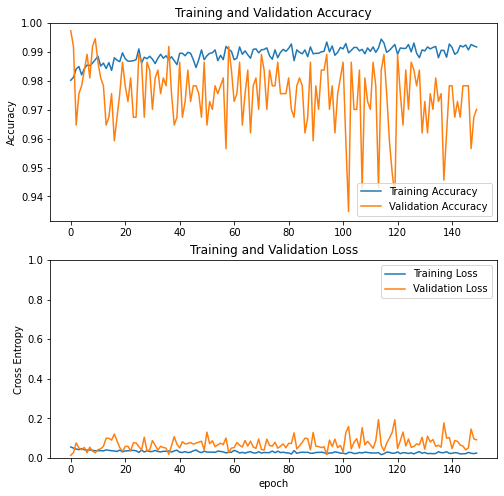

In [17]:
plot(history)